# Sentiment Analysis from Tweets

This coursework will involve you implementing functions for a text classifier, which you will train to identify the **sentiment expressed in a text** in a dataset of approx. 27,000 entries, which will be split into a 80%/20% training/test split.

In this template you are given the basis for that implementation, though some of the functions are missing, which you have to fill in.

Follow the instructions file **NLP_Assignment_1_Instructions.pdf** for details of each question - the outline of what needs to be achieved for each question is as below.

You must submit all **ipython notebooks and extra resources you need to run the code if you've added them** in the code submission, and a **2 page report (pdf)** in the report submission on QMPlus where you report your methods and findings according to the instructions file for each question.

In [74]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np

In [75]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

# Question 1: Input and Basic preprocessing (10 marks)

In [76]:
def parse_data_line(data_line):
    # Should return a tuple of the label as just positive or negative and the statement
    # e.g. (label, statement)
    # Simply returning the 2nd (index 1) and 3rd (index 2) items in the line which are the label and statement respectively
    return (data_line[1], data_line[2])

In [77]:
# Q5: Downloading NLTK stop words for stop word removal
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

import re
# Input: a string of one statement
def pre_process(text):
    # Should return a list of tokens
    # DESCRIBE YOUR METHOD IN WORDS
    # Using regex for seperating punctuation at end of strings
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text)
    # Using regex for seperating punctuation at the beginning of strings
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text)
    # Using function re.split() to split text at spaces and convert to a list of words
    tokens = re.split(r"\s+",text)
    # Using function string.lower() convert all tokens to lowercase
    tokens = [t.lower() for t in tokens if t not in stop]
    # Returning the list of tokens
    return tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Question 2: Basic Feature Extraction (20 marks)

In [78]:
global_feature_dict = {} # A global dictionary of features

def to_feature_vector(tokens):
    # Should return a dictionary containing features as keys, and weights as values
    # DESCRIBE YOUR METHOD IN WORDS
    # Initializing a new dictionary to store bag of words from the list tokens
    # This dictionary will only contain the bag of words representation for the current list of tokens
    dict_ = {}
    # For loop iterating over the list of tokens
    for t in tokens:
      # Updating dict_ when the word is already present in dict_
      if t in dict_:
        # Simply adding 1 to the word's value
        dict_[t] += 1
      # Updating dict_ when the word is not present in dict_
      else:
        # Adding a new entry in dict_ with its value set to 1
        dict_.update({t: 1})
      # Now updating the global dictionary global_feature_dict
      # This dictionary will contain the bag of words representation for the entire dataset
      # Updating global_feature_dict when the word is already present in diglobal_feature_dictct_
      if t in global_feature_dict:
        # Simply adding 1 to the word's value
        global_feature_dict[t] += 1
      # Updating global_feature_dict when the word is not present in global_feature_dict
      else:
        # Adding a new entry in global_feature_dict with its value set to 1
        global_feature_dict.update({t: 1})
    # Returning the dictionary containing the bag of words represenation for the current list of tokens
    return dict_

In [79]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(data)

# Question 3: Cross-validation (20 marks)

In [80]:
#solution
from sklearn.metrics import classification_report

def cross_validate(dataset, folds):
    results = []
    fold_size = int(len(dataset)/folds) + 1

    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        print("Fold start on items %d - %d" % (i, i+fold_size))
        # FILL IN THE METHOD HERE
        # Creating a test dataset named test_data_ (using different name from the global variable test_data)
        # Populating test_data_ with data from one fold
        test_data_ = dataset[i:i+fold_size]
        # Creating a training dataset named train_data_ (using different name from the global variable train_data)
        # Populating train_data_ with data from one fold
        train_data_ = dataset[:i] + dataset[i+fold_size:]
        # Creating a classifier trained on the dataset train_data_
        classifier = train_classifier(train_data_)
        # Seperating the true labels for the test dataset
        test_true = [t[1] for t in test_data_]
        # Seperating the features for the test dataset
        test_features = [t[0] for t in test_data_]
        # Using the classifier trained on the training dataset to get predicted labels for test dataset
        test_pred = predict_labels(test_features, classifier)
        # Using sklearn.metrics.classification_report function to get evaluation metrics for the classifier on the test dataset
        report = classification_report(test_true, test_pred, output_dict=True)
        # Using weighted precision, recall, and f1 score (as per the metrics at the bottom of the notebook for final testing)
        weighted = report['weighted avg']
        # Extracting precision from the dictionary containing weighted precision, recall, and f1 score
        precision = weighted['precision']
        # Extracting recall from the dictionary containing weighted precision, recall, and f1 score
        recall = weighted['recall']
        # Extracting f1 score from the dictionary containing weighted precision, recall, and f1 score
        fscore = weighted['f1-score']
        # Extracting accuracy from the dictionary containing the report
        accuracy = report['accuracy']
        # Putting precision, recall, fscore (the f1 score), and accuracy in a list and appending it to the list result
        results.append([precision, recall, fscore, accuracy])
    # Creating an np arrayy from the list result which contains a list [precision, recall, fscore, accuracy] for
    #   every iteration of cross validation resulting into a array of shape (folds, 4)
    # Taking a columnwise mean of the array resulting in the mean of the metrics precision, recall, f1 score, and accuracy
    #   across all the folds
    # Storing the averages of the metrics as a list in the variable cv_results
    cv_results = np.array(results).mean(axis = 0).tolist()
    # Returning cv_results
    return cv_results

In [81]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [82]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'sentiment-dataset.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path)

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 33540 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 33540 rawData, 26832 trainData, 6708 testData
Training Samples: 
26832
Features: 
64633


In [83]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Fold start on items 0 - 2684
Training Classifier...
Fold start on items 2684 - 5368
Training Classifier...
Fold start on items 5368 - 8052
Training Classifier...
Fold start on items 8052 - 10736
Training Classifier...
Fold start on items 10736 - 13420
Training Classifier...
Fold start on items 13420 - 16104
Training Classifier...
Fold start on items 16104 - 18788
Training Classifier...
Fold start on items 18788 - 21472
Training Classifier...
Fold start on items 21472 - 24156
Training Classifier...
Fold start on items 24156 - 26840
Training Classifier...


[0.838769762419323, 0.8399714635140644, 0.8390102845819761, 0.8399714635140644]

# Question 4: Error Analysis (20 marks)

In [84]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    # cm = metrics.confusion_matrix(y_test, preds, labels)
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')

    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

Error analysis for fold 0 - 2684
Training Classifier...


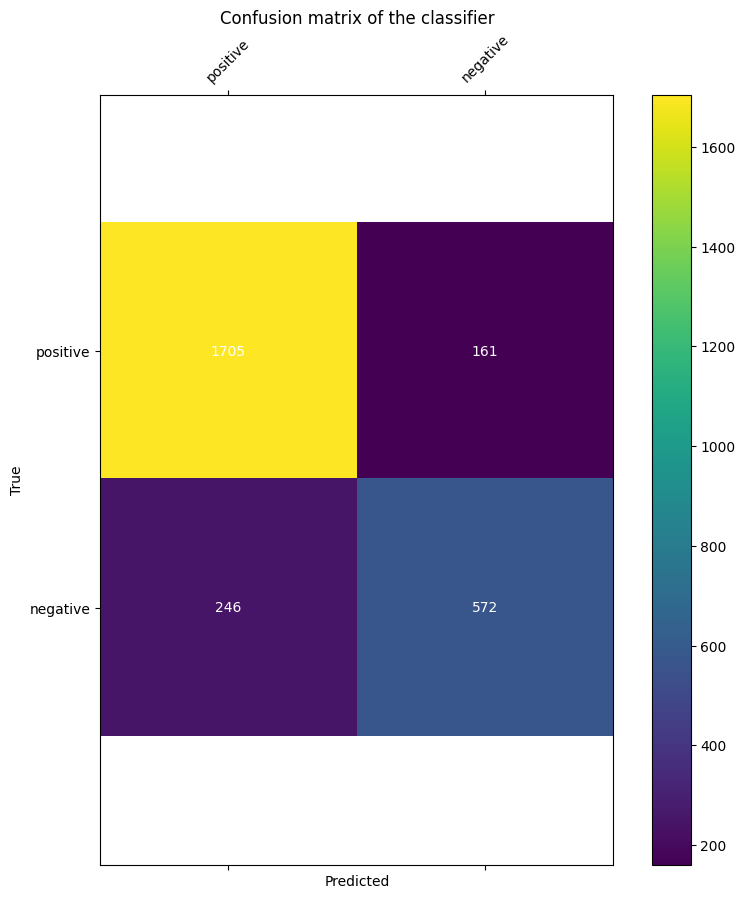

In [85]:
# Creating a function for error analysis
def error_analysis(dataset):
    # Setting up for one iteration of cross validation
    # Setting start as 0, folds as 10, and using the same formula from provided code for fold_size
    start = 0
    folds = 10
    fold_size = int(len(dataset)/folds) + 1
    print("Error analysis for fold %d - %d" % (start, fold_size))
    # Creating a test dataset named test_data_ (using different name from the global variable test_data)
    # Populating test_data_ with data from one fold
    test_data_ = dataset[start:start+fold_size]
    # Creating a training dataset named train_data_ (using different name from the global variable train_data)
    # Populating train_data_ with data from one fold
    train_data_ = dataset[:start] + dataset[start+fold_size:]
    # Creating a classifier trained on the dataset train_data_
    classifier = train_classifier(train_data_)  # train the classifier
    # Seperating the true labels for the test dataset
    test_true = [t[1] for t in test_data_]
    # Seperating the features for the test dataset
    test_features = [t[0] for t in test_data_]
    # Using the classifier trained on the training dataset to get predicted labels for test dataset
    test_pred = predict_labels(test_features, classifier)
    # Using the provided function to create a heatmap of the confusion matrix
    confusion_matrix_heatmap(test_true, test_pred, ['positive', 'negative'])

    # Opening a file to output all the false positives and false negatives for the positive label
    f = open("positive_label_error_analysis.tsv", "w")
    # Adding header
    print('TRUE\tPRED\tTEXT', file = f)
    # Adding line to mark false positives
    print('********************************** FALSE POSITIVES **********************************', file = f)
    # Going through the entire test dataset
    for i in range(len(test_true)):
      # Looking at all cases where true and predicted labels are different
      if test_true[i] != test_pred[i]:
        # If the true label is negative (predicted label is positive), this is a false positive for class positive
        if (test_true[i] == 'negative'):
          # Adding the true label, predicted label, and the features
          print("%s %s %s" % (test_true[i], test_pred[i], test_features[i]), file = f)
    # Adding line to mark false negatives
    print('********************************** FALSE NEGATIVES **********************************', file = f)
    # Going through the entire test dataset
    for i in range(len(test_true)):
      # Looking at all cases where true and predicted labels are different
      if test_true[i] != test_pred[i]:
        # If the true label is positive (predicted label is negative), this is a false negative for class positive
        if (test_true[i] == 'positive'):
          print("%s %s %s" % (test_true[i], test_pred[i], test_features[i]), file = f)
    f.close()

error_analysis(train_data)

# Questions 5: Optimising pre-processing and feature extraction (30 marks)

**Note:** it is advisable to implement question 5 in a separate notebook where you further develop the pre-processing and feature extraction functions you implemented above.

In [86]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

({'tomorrow': 1, "'": 2, 'release': 1, '58th': 1, 'episode': 1, '#hsonair': 1, 'profiling': 1, '@alissadossantos': 1, '!': 2, 'we': 1, 'talk': 1, 'storytelling': 1, 'beyonce': 1}, 'positive')
Training Classifier...
Done training!
Precision: 0.848257
Recall: 0.849583
F Score:0.848649
